In [1]:
from __future__ import annotations
import typing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import os
import copy
import pickle
import time
from tqdm import tqdm

torch.manual_seed(3654)

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Get Text Data

In [9]:
#We are only using the tweet column from TweetsElonMusk.csv
#df = pd.read_csv("/content/drive/MyDrive/GPT/TweetsElonMusk.csv", usecols=["tweet"])
#print(df.size)

In [10]:
# read it in to inspect it
with open('/content/drive/MyDrive/GPT/Harry_Potter_all_books_preprocessed.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [11]:
# text = '\n'.join(df['tweet'].astype(str).values)

In [12]:
print(len(text))

5991293


In [13]:
print(text[:100])

THE BOY WHO LIVED Mr and Mrs Dursley of number four Privet Drive were proud to say that they were pe


## Encoder


In [14]:
char_vocab = sorted(set(text))
char_vocab_size = len(char_vocab)
print(f"char_vocab_size is {char_vocab_size}")
print(char_vocab)

char_vocab_size is 71
[' ', '!', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '~', '‘', '•', '■', '□']


In [15]:
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(char_vocab) }
itos = { i:ch for i,ch in enumerate(char_vocab) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

print(encode("hii there"))
print(decode(encode("hii there")))

[47, 48, 48, 0, 59, 47, 44, 57, 44]
hii there


In [16]:
# let's now encode the entire text dataset and store it into a torch.Tensor
import torch # we use PyTorch: https://pytorch.org
data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:1000]) # the 1000 characters we looked at earier will to the GPT look like this

torch.Size([5991293]) torch.int64
tensor([33, 21, 18,  0, 15, 28, 38,  0, 36, 21, 28,  0, 25, 22, 35, 18, 17,  0,
        26, 57,  0, 40, 53, 43,  0, 26, 57, 58,  0, 17, 60, 57, 58, 51, 44, 64,
         0, 54, 45,  0, 53, 60, 52, 41, 44, 57,  0, 45, 54, 60, 57,  0, 29, 57,
        48, 61, 44, 59,  0, 17, 57, 48, 61, 44,  0, 62, 44, 57, 44,  0, 55, 57,
        54, 60, 43,  0, 59, 54,  0, 58, 40, 64,  0, 59, 47, 40, 59,  0, 59, 47,
        44, 64,  0, 62, 44, 57, 44,  0, 55, 44, 57, 45, 44, 42, 59, 51, 64,  0,
        53, 54, 57, 52, 40, 51,  0, 59, 47, 40, 53, 50,  0, 64, 54, 60,  0, 61,
        44, 57, 64,  0, 52, 60, 42, 47,  0,  2, 33, 47, 44, 64,  0, 62, 44, 57,
        44,  0, 59, 47, 44,  0, 51, 40, 58, 59,  0, 55, 44, 54, 55, 51, 44,  0,
        64, 54, 60, 43,  0, 44, 63, 55, 44, 42, 59,  0, 59, 54,  0, 41, 44,  0,
        48, 53, 61, 54, 51, 61, 44, 43,  0, 48, 53,  0, 40, 53, 64, 59, 47, 48,
        53, 46,  0, 58, 59, 57, 40, 53, 46, 44,  0, 54, 57,  0, 52, 64, 58, 59,
      

In [17]:
# Let's now split up the data into train and validation sets
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

In [18]:
block_size = 8
train_data[:block_size+1]

tensor([33, 21, 18,  0, 15, 28, 38,  0, 36])

In [19]:
x = train_data[:block_size]
y = train_data[1:block_size+1]
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"when input is {context} the target: {target}")

when input is tensor([33]) the target: 21
when input is tensor([33, 21]) the target: 18
when input is tensor([33, 21, 18]) the target: 0
when input is tensor([33, 21, 18,  0]) the target: 15
when input is tensor([33, 21, 18,  0, 15]) the target: 28
when input is tensor([33, 21, 18,  0, 15, 28]) the target: 38
when input is tensor([33, 21, 18,  0, 15, 28, 38]) the target: 0
when input is tensor([33, 21, 18,  0, 15, 28, 38,  0]) the target: 36


In [20]:
torch.manual_seed(1337)
batch_size = 4 # how many independent sequences will we process in parallel?
block_size = 8 # what is the maximum context length for predictions?

def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y

xb, yb = get_batch('train')
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

print('----')

for b in range(batch_size): # batch dimension
    for t in range(block_size): # time dimension
        context = xb[b, :t+1]
        target = yb[b,t]
        print(f"when input is {context.tolist()} the target: {target}")

inputs:
torch.Size([4, 8])
tensor([[64, 54, 60,  0, 50, 53, 54, 62],
        [55, 40, 57, 50,  0,  2, 28, 53],
        [59, 44, 57, 41, 44, 44, 57,  0],
        [44, 40, 42, 47, 44, 57, 58,  0]])
targets:
torch.Size([4, 8])
tensor([[54, 60,  0, 50, 53, 54, 62,  0],
        [40, 57, 50,  0,  2, 28, 53, 44],
        [44, 57, 41, 44, 44, 57,  0, 42],
        [40, 42, 47, 44, 57, 58,  0, 43]])
----
when input is [64] the target: 54
when input is [64, 54] the target: 60
when input is [64, 54, 60] the target: 0
when input is [64, 54, 60, 0] the target: 50
when input is [64, 54, 60, 0, 50] the target: 53
when input is [64, 54, 60, 0, 50, 53] the target: 54
when input is [64, 54, 60, 0, 50, 53, 54] the target: 62
when input is [64, 54, 60, 0, 50, 53, 54, 62] the target: 0
when input is [55] the target: 40
when input is [55, 40] the target: 57
when input is [55, 40, 57] the target: 50
when input is [55, 40, 57, 50] the target: 0
when input is [55, 40, 57, 50, 0] the target: 2
when input is [55,

In [21]:
print(xb) # our input to the transformer

tensor([[64, 54, 60,  0, 50, 53, 54, 62],
        [55, 40, 57, 50,  0,  2, 28, 53],
        [59, 44, 57, 41, 44, 44, 57,  0],
        [44, 40, 42, 47, 44, 57, 58,  0]])


# Bigram Model

In [22]:
import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)

class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets=None):

        # idx and targets are both (B,T) tensor of integers
        logits = self.token_embedding_table(idx) # (B,T,C)
        
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # get the predictions
            logits, loss = self(idx)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = BigramLanguageModel(char_vocab_size).to(device)
logits, loss = model(xb, yb)
print(logits.shape)
print(loss)

print(decode(model.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=100)[0].tolist()))

torch.Size([32, 71])
tensor(4.8702, grad_fn=<NllLossBackward0>)
 3yhb■rnCYI1Z‘ZjKrtYdC2dB5iWFK!vIH4VBji6Nes8szMeFzq5ic5■C□55VED?VB9sYz‘OAtayh6Mes8‘Zj4nQj?r2TEi5rIFqB


In [23]:
# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

In [24]:
batch_size = 32
losses = []

for steps in range(10000): # increase number of steps for good results... 
    
    ## we can also figure out our loss function : -ln(1/char_vocab_size)

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    

    losses.append(loss.item())

print(loss.item())


2.351505994796753


In [25]:
print(decode(model.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=2000)[0].tolist()))

 o bory irn wavep in usseathabe inthinds ldemit d tensibo .THars Dud id .y ts we atothef mashitog cryooorth .Tomes Ron ly he y m qvoped Mrst t P■ze hathe bugr pay a tawhey tano y .Yof Cl n a he m I auner Crsthask s .He hiewame tithe .Roulawaroulyerr jurolchetr s f frory cke her ht enk blecke anin m‘Vme Obry am bar chthe safllthatheng hous s Ume hextey alurie in w rom .The onpred blffrestr lal yer sof He hsastin ntsageasstorsay he itoly cenarne d s t medore hemsthan asanome y aneyotid hind stofo stshe y tur wistede s chedof sande .THake ts wiund tht?armpid ik dge h t jur bl hien thelke Frarmsndind .Slory dd h f nop Hibonewanelaboff .Anttag ceery lyLumalestagre CORoplape horeat rowind bugon hr d y 123k Werinot t sasout tif ss t aser in abery tre s .Sheaid Halleankslast and aid wing Rore De y ffber Hadee tlese .Dutok sppso9u for ss tulolowhise are hain t nvistetamitherourin perer mimes lfomup t cero lom ay Rous t hengnge ariethaGrkss uid toublyorexin shas d m aisthily fang Po .Yes uthThex

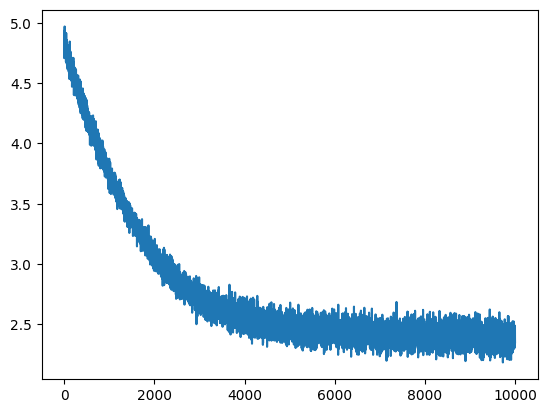

In [26]:
import matplotlib.pyplot as plt

plt.plot(losses)


# Attention

## Math trick in Self Attention


In [27]:
#consider the toy example:

torch.manual_seed(1337)
B, T, C = 4, 8, 2 # batch, time, channels
x = torch.randn(B,T,C)
x.shape

#information only flows in the previous time stamp

torch.Size([4, 8, 2])

What is the easiest way for tokens to communicate? 
At $n^{th}$ token, take an avg of all preceding tokens --> feature vector that "summarizes" $n^{th}$ in the context of its history
Of course, taking an avg is weak and lossy to represent that context

In [28]:
# We want x[b,t] = mean_{i<=t} x[b,i]
#xbow -> x bag of words
xbow = torch.zeros((B,T,C))
for b in range(B):
    for t in range(T):
        xprev = x[b,:t+1] # (t,C)     we are including the tth token 
        xbow[b,t] = torch.mean(xprev, 0)

In [29]:
# self-attention!
torch.manual_seed(1337)
B,T,C = 4,8,32 # batch, time, channels
x = torch.randn(B,T,C)

# let's see a single Head perform self-attention
head_size = 16 
key = nn.Linear(C, head_size, bias=False) # what do i contain
query = nn.Linear(C, head_size, bias=False) # what am i looking for
value = nn.Linear(C, head_size, bias=False)
k = key(x)   # (B, T, 16)
q = query(x) # (B, T, 16)
# wei is dot product of key and query
# we transpose the last two dimensions of key .transpose(-2, -1)
wei =  q @ k.transpose(-2, -1) # (B, T, 16) @ (B, 16, T) ---> (B, T, T)  

tril = torch.tril(torch.ones(T, T))
#wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1)

v = value(x)
out = wei @ v
#out = wei @ x

out.shape

torch.Size([4, 8, 16])

- "self-attention" just means that the keys and values are produced from the same source as queries (in this case, x). In "cross-attention", the queries still get produced from x, but the keys and values come from some other, external source (e.g. an encoder module)
- "Scaled" attention additional divides wei by 1/sqrt(head_size). This makes it so when input Q,K are unit variance, wei will be unit variance too and Softmax will stay diffuse and not saturate too much. Illustration below

In [3]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.2
# ------------

torch.manual_seed(1337)

# harry potter text
with open('/content/drive/MyDrive/GPT/Harry_Potter_all_books_preprocessed.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

# super simple bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = BigramLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))


0.210503 M parameters
step 0: train loss 4.4448, val loss 4.4456
step 100: train loss 2.5406, val loss 2.5135
step 200: train loss 2.4087, val loss 2.3873
step 300: train loss 2.3321, val loss 2.3173
step 400: train loss 2.2724, val loss 2.2549
step 500: train loss 2.2172, val loss 2.1965
step 600: train loss 2.1505, val loss 2.1398
step 700: train loss 2.1009, val loss 2.0871
step 800: train loss 2.0533, val loss 2.0466
step 900: train loss 2.0135, val loss 2.0100
step 1000: train loss 1.9801, val loss 1.9653
step 1100: train loss 1.9459, val loss 1.9367
step 1200: train loss 1.9240, val loss 1.9053
step 1300: train loss 1.8819, val loss 1.8940
step 1400: train loss 1.8762, val loss 1.8786
step 1500: train loss 1.8536, val loss 1.8510
step 1600: train loss 1.8387, val loss 1.8404
step 1700: train loss 1.8113, val loss 1.8300
step 1800: train loss 1.8201, val loss 1.8195
step 1900: train loss 1.7896, val loss 1.8003
step 2000: train loss 1.7788, val loss 1.7793
step 2100: train loss 1.